In [8]:
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D,LSTM, BatchNormalization, Conv2DTranspose,Flatten, Input, Reshape, UpSampling2D,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam

In [9]:
def generate_data_as_images(N,l=100,T=1, dt = 0.001):
    
    #Model parameters
    #dt = 0.001 # integration time step
    sigma = 10
    rho = 28
    beta = 8/3
    #l = int((T-dt)/dt)
    
    #T = dt*(l+1)
    #dt = T/(l+1)
    
    #X = np.zeros((N,3*(l-9)))
    X = []
    for n in range(N):    

        x0 = [np.random.randn(), np.random.randn(), np.random.randn()]

        # generate the Lorenz-63 system
        x = odeint(Lorenz_63, x0, np.arange(0.01,T,dt), args=(sigma, rho, beta))
        #X[n,...] = np.ndarray.flatten(x)
        #X.append(np.ndarray.flatten(x))
        X.append(x.reshape(x.shape[0]*x.shape[1]))

    return np.array(X)

# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = np.zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

In [97]:
N = 100
X = generate_data_as_images(N,T=100, dt=0.1)

n_rows = 56
n_cols = 56
X_padded = np.zeros((X.shape[0],n_rows*n_cols))
X_padded[:,:X.shape[1]] = X
X_padded = X_padded.reshape(X.shape[0],n_rows,n_cols,1)

X_train, X_test = train_test_split(X_padded, test_size=0.33, random_state=42)
X_train.shape

(67, 56, 56, 1)

In [144]:
max_vec = np.max(np.max(abs(X_padded),axis=1),axis=1)
max_matrix = np.repeat(np.repeat(max_vec, 56, axis=1),56,axis=1).reshape(len(max_vec),56,56,1)
X_normalized = np.divide(X_padded,max_matrix)

In [146]:
class gan_CNN(object): 

    def __init__(self):

        self.noise_dim = 300
        self.img_cols = 56
        self.img_rows = 56
        self.channels = 1
        self.optimizer_gan = Adam(0.0001, 0.5)
        self.optimizer_discriminator = Adam(0.0004, 0.5)

        
        self.generator = Sequential() 
        self.discriminator = Sequential()
        self.gan = Model()
        
        self.create_generator()
        self.create_discriminator()
        self.create_gan()

    def create_generator(self):
        
        # Starting size
        d = 7
        self.generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=self.noise_dim))
        self.generator.add(LeakyReLU(0.2))
        # 4x4x256
        self.generator.add(Reshape((d, d, 256)))
        
        # 8x8x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(LeakyReLU(0.2))
        
        # 16x16*128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x128
        self.generator.add(Conv2DTranspose(128, (d, d), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.generator.add(LeakyReLU(0.2))
        
        # 32x32x3
        self.generator.add(Conv2D(self.channels, (3, 3), padding='same', activation='linear', kernel_initializer=RandomNormal(0, 0.02)))
        # activation should be linear
        
        self.generator.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
      
    def create_discriminator(self):

        self.discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(self.img_cols, self.img_rows, self.channels)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
        self.discriminator.add(LeakyReLU(0.2))

        self.discriminator.add(Flatten())
        self.discriminator.add(Dropout(0.4))
        self.discriminator.add(Dense(1, activation='sigmoid', input_shape=(self.img_cols, self.img_rows, self.channels)))

        self.discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer_discriminator)

    def create_gan(self):

        # Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
        self.discriminator.trainable = False

        # Link the two models to create the GAN
        gan_input = Input(shape=(self.noise_dim,))
        fake_image = self.generator(gan_input)

        gan_output = self.discriminator(fake_image)

        self.gan = Model(gan_input, gan_output)
        self.gan.compile(loss='binary_crossentropy', optimizer=self.optimizer_gan)
    
    def gan_summary(self):
        
        self.gan.summary()
        
    def generator_summary(self):
        
        self.generator.summary()

    def discriminator_summary(self):
        
        self.discriminator.summary()
        
    def train(self,X_train, epochs=1, batch_size=128):

        #Loading the data
        batch_count = int((X_train.shape[0] / batch_size))+1

        loss_list_generator = []
        loss_list_discriminator = []
        for e in range(1,epochs+1 ):
            print("Epoch %d" %e)
            loss_generator = 0
            loss_discriminator = 0
            idx = np.random.randint(0,X_train.shape[0],X_train.shape[0])
            
            max_noise = 10
            if e < 0.2 * (epochs+1):
                noise_std = max_noise
            elif e < 0.4 * (epochs+1):
                noise_std = max_noise
            elif e < 0.6 * (epochs+1):
                noise_std = max_noise/2
            elif e < 0.8 * (epochs+1):
                noise_std = max_noise/6
            elif e < 0.9 * (epochs+1):
                noise_std = max_noise/10
            else:
                noise_std = 0
                
            print('Noise std: ', noise_std)

            for _ in tqdm(range(batch_count)):
                
                # Real trajectories
                real_trajectory = X_train[idx[batch_size*_:batch_size*_+batch_size,...]]

                N = np.shape(real_trajectory)[0]#we now use N instead of batch_size, as the last batch
                                                #may be smaller than the batch size
                #real_trajectory = real_trajectory.reshape(N, self.img_rows, self.img_cols, self.channels)
                #generate  random noise as an input  to  initialize the  generator
                
                noise= np.random.normal(0,1, [N, self.noise_dim])

                generated_trajectory = self.generator.predict(noise)#.reshape(N,100,3)

                #Construct different batches of  real and fake data 
                X= np.concatenate([real_trajectory, generated_trajectory], axis=0) + noise_std * np.random.randn(2*N,n_rows,n_cols,1)

                # Labels for generated and real data
                y_dis=np.zeros(2*N)
                y_dis[:N]= 0.8 #0.9bat
                y_dis[N:2*N]= 0.2 #0.2bat
                
                # we try the discriminator in about one third of the total cases
                if e % 3 == 0:

                    #Pre train discriminator on  fake and real data  before starting the gan. 
                    self.discriminator.trainable=True

                    loss_discriminator = loss_discriminator + self.discriminator.train_on_batch(X, y_dis)

                #Tricking the noised input of the Generator as real data
                noise= np.random.normal(0,1, [N, self.noise_dim])
                y_gen = 0.2*np.ones(N)

                # During the training of gan, 
                # the weights of discriminator should be fixed. 
                #We can enforce that by setting the trainable flag
                self.discriminator.trainable=False

                #training  the GAN by alternating the training of the Discriminator 
                #and training the chained GAN model with Discriminator’s weights freezed.
                loss_generator = loss_generator + self.gan.train_on_batch(noise, y_gen)
                
            if e % 3 != 0 and e != 1:
                
                loss_discriminator = loss_list_discriminator[-1]
                
            loss_list_generator.append(loss_generator)
            loss_list_discriminator.append(loss_discriminator)
                                           
            print('Generator loss: ',loss_generator)
            print('Discriminator loss: ',loss_discriminator)
            
            if e == 1 or e % 20 == 0:

                plt.imshow(X[0,:,:,0])
                plt.colorbar()
                plt.show()
                plt.imshow(X[-1,:,:,0])
                plt.colorbar()
                plt.show()
                
        return loss_list_generator, loss_list_discriminator

            
    def generate(self,N):

        noise= np.random.normal(0,1, [N, self.noise_dim])

        return np.transpose(self.generator.predict(noise))
    
    def save_weighst(self, gen_name, discr_name):
        
        self.generator.save_weights(gen_name)
        self.discriminator.save_weights(discr_name)
        
    def load_weighst(self, gen_name, discr_name):
        
        self.generator.load_weights(gen_name)
        self.discriminator.load_weights(discr_name)
      

In [147]:
g_CNN=gan_CNN()
g_CNN.generator_summary()
g_CNN.discriminator_summary()
g_CNN.gan_summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 12544)             3775744   
_________________________________________________________________
leaky_re_lu_128 (LeakyReLU)  (None, 12544)             0         
_________________________________________________________________
reshape_16 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 14, 14, 128)       1605760   
_________________________________________________________________
leaky_re_lu_129 (LeakyReLU)  (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_49 (Conv2DT (None, 28, 28, 128)       802944    
_________________________________________________________________
leaky_re_lu_130 (LeakyReLU)  (None, 28, 28, 128)     

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1
Noise std:  10


100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Generator loss:  2.772434651851654
Discriminator loss:  0


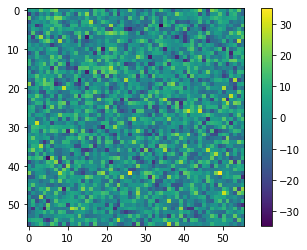

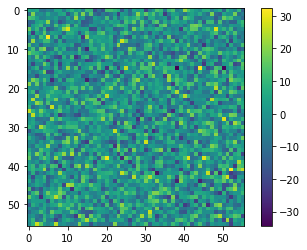

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2
Noise std:  10


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7713924646377563
Discriminator loss:  0
Epoch 3
Noise std:  10


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.767746686935425
Discriminator loss:  2.7747235894203186
Epoch 4
Noise std:  10


  0%|          | 0/4 [00:00<?, ?it/s]

Generator loss:  2.7502665519714355
Discriminator loss:  2.7747235894203186
Epoch 5
Noise std:  10


  0%|          | 0/4 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [148]:
loss_generator,loss_discriminator = g_CNN.train(X_normalized,400,30)

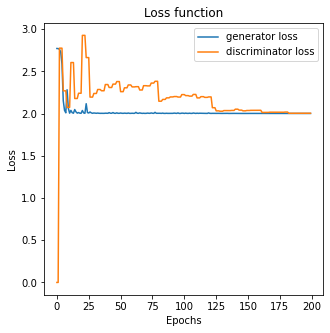

In [130]:
plt.figure(figsize=(5,5))
plt.plot(loss_generator)
plt.plot(loss_discriminator)
plt.title('Loss function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss','discriminator loss'])
plt.show()

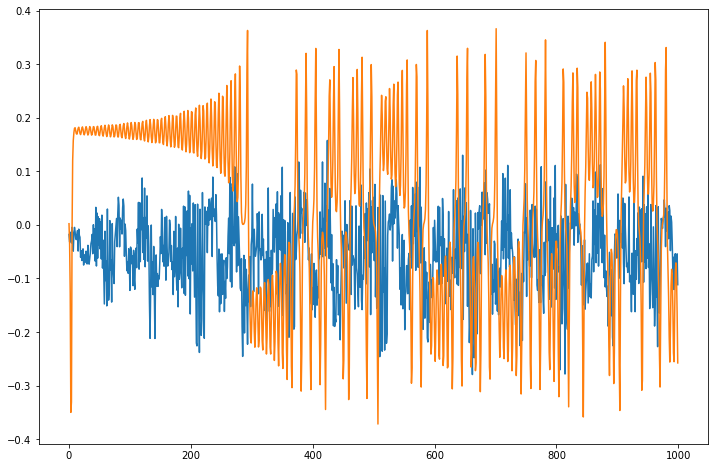

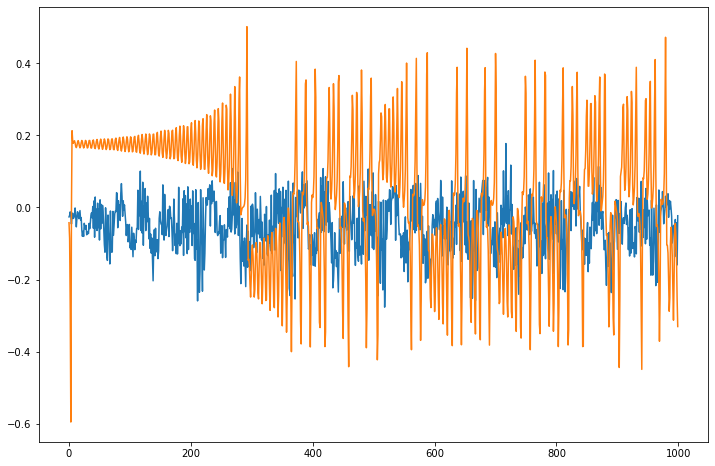

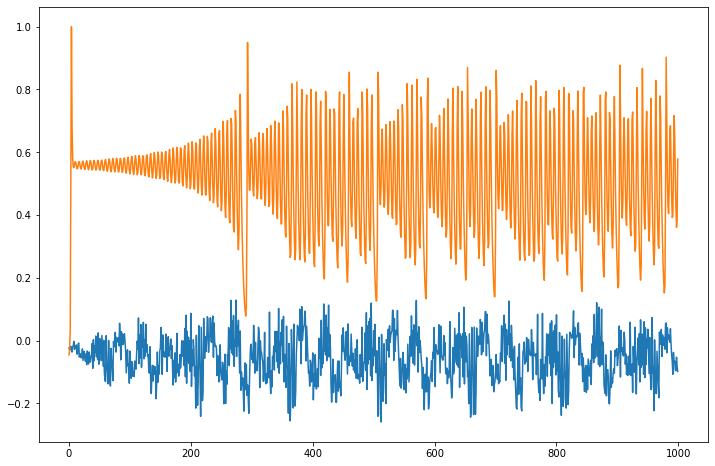

In [145]:
x_train = X_normalized[0,:,:].reshape(X_padded.shape[1]*X_padded.shape[2])[:X.shape[1]].reshape(int(X.shape[1]/3),3)
#max_matrix = np.repeat(np.max(abs(x_train),axis=0).reshape(1,3),1000,axis=0)
#x_train = np.divide(x_train,max_matrix)

generated_data = g_CNN.generate(1)
generated_data = generated_data.reshape(n_rows,n_cols)

generated_data = generated_data.reshape(generated_data.shape[0]*generated_data.shape[1],1)[:X.shape[1]].reshape(int(X.shape[1]/3),3)

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,0])
plt.plot(x_train[:,0])
#plt.xlim([0,200])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,1])
plt.plot(x_train[:,1])
#plt.xlim([0,200])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,2])
plt.plot(x_train[:,2])
plt.show()

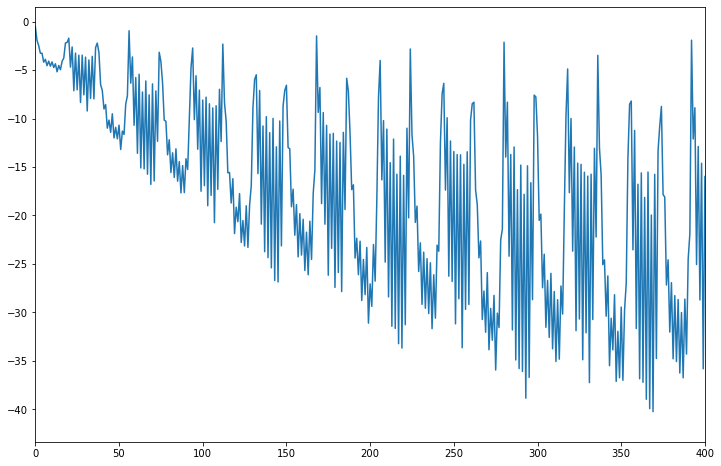

In [105]:
x_train = X_padded[0,:,:].reshape(X_padded.shape[1]*X_padded.shape[2])[:X.shape[1]].reshape(int(X.shape[1]/3),3)
#max_matrix = np.repeat(np.max(abs(x_train),axis=0).reshape(1,3),1000,axis=0)
#x_train = np.divide(x_train,max_matrix)

generated_data = g_CNN.generate(1)
generated_data = generated_data.reshape(n_rows,n_cols)

generated_data = generated_data.reshape(generated_data.shape[0]*generated_data.shape[1],1)[:X.shape[1]].reshape(int(X.shape[1]/3),3)

plt.figure(figsize=(12,8))
plt.plot(generated_data[:,0])
plt.xlim([0,400])
plt.show()


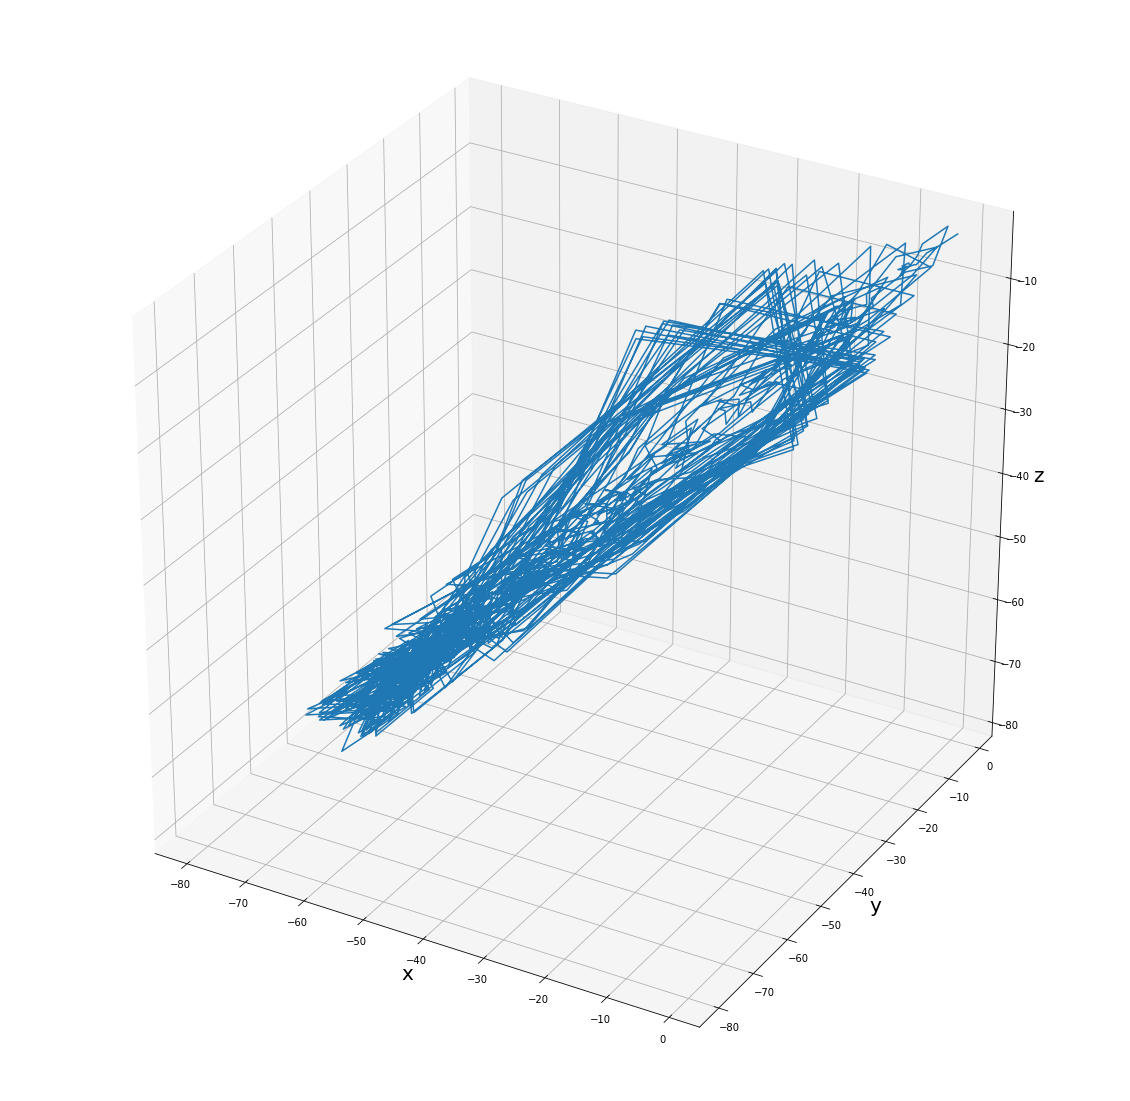

In [43]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.plot(generated_data[:,0], generated_data[:,1], generated_data[:,2])
ax.set_xlabel('x', size=20);ax.set_ylabel('y', size=20);ax.set_zlabel('z', size=20)
plt.show()

In [93]:
max_matrix = np.repeat(np.max(abs(X_padded),axis=0).reshape(1,3),1000,axis=0)
X_padded = np.divide(X_padded,max_matrix)

ValueError: cannot reshape array of size 3136 into shape (1,3)

In [133]:
X_padded.shape

(100, 56, 56, 1)

In [142]:
max_vec = np.max(np.max(abs(X_padded),axis=1),axis=1)
max_matrix = np.repeat(np.repeat(max_vec, 56, axis=1),56,axis=1).reshape(len(max_vec),56,56,1)
X_normalized = np.divide(X_padded,max_matrix)

In [143]:
X_normalized.shape

(100, 56, 56, 1)